In [67]:
import itertools
import time
import simpy
from tkinter import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tkinter as tk
import json
import math
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import ImageTk
import os
def run_simulation(RFID_GATE_LINES = 2, PAPER_GATE_LINES = 2, PAPER_EMPS_PER_LINE = 1, RFID_EMPS_PER_LINE = 0.5, RFID_SELECTION_RATE = 0.7):
    ######################
    ##### INPUTS #########
    ######################
    RFID_GATE_LINES = RFID_GATE_LINES
    PAPER_GATE_LINES = PAPER_GATE_LINES

    PAPER_EMPS_PER_LINE = PAPER_EMPS_PER_LINE
    RFID_EMPS_PER_LINE = RFID_EMPS_PER_LINE

    ######################
    ### CONFIGURATIONS ###
    ######################
    RFID_SELECTION_RATE = RFID_SELECTION_RATE

    RFID_SCAN_TIME_MIN = 9
    RFID_SCAN_TIME_MAX = 13
    PAPER_SCAN_TIME_MIN = 10
    PAPER_SCAN_TIME_MAX = 17

    JOIN_RATE_HIGH_MEAN = 3
    JOIN_RATE_HIGH_STD = 0.5

    JOIN_RATE_AVG_MEAN = 30
    JOIN_RATE_AVG_STD = 1

    JOIN_RATE_LOW_MEAN = 60
    JOIN_RATE_LOW_STD = 10

    ERROR_RATE_RFID = 0.01
    ERROR_RATE_PAPER = 0.035
    # Creating the 'output' directory if it doesn't exist
    os.makedirs('output', exist_ok=True)
    # Xây dựng các hàm cho chương trình chính
    
## NHÓM HÀM BỔ TRỢ

    def get_current_time(elapsed_seconds):
        start_time = datetime.strptime('06:30:00', '%H:%M:%S')
        current_time = start_time + timedelta(seconds=elapsed_seconds)
        formatted_current_time = current_time.strftime('%H:%M:%S')
        return formatted_current_time

    def check_traffic_status(current_time):

        if current_time < "08:30:00":
            return "low"
        elif "08:30:00" <= current_time < "09:30:00":
            return "avg"
        elif "09:30:00" <= current_time < "10:30:00":
            return "high"
        elif "10:30:00" <= current_time < "11:30:00":
            return "avg"
        elif "11:30:00" <= current_time < "12:30:00":
            return "high"
        elif "12:30:00" <= current_time < "14:30:00":
            return "low"
        elif "14:30:00" <= current_time < "15:30:00":
            return "avg"
        elif "15:30:00" <= current_time < "16:30:00":
            return "high"
        elif "16:30:00" <= current_time < "18:30:00":
            return "avg"
        elif "18:30:00" <= current_time < "19:30:00":
            return "high"
        else:
            return "low"
    def generate_scan_time(card_type):
        if card_type == 'RFID':
            return random.uniform(RFID_SCAN_TIME_MIN, RFID_SCAN_TIME_MAX)
        elif card_type == 'paper':
            return random.uniform(PAPER_SCAN_TIME_MIN, PAPER_SCAN_TIME_MAX)
        

    def generate_arrival_time(env):
        current_time = get_current_time(env.now)
        traffic_status = check_traffic_status(current_time)
        if traffic_status == 'high':
            arrival_time = max(0, random.normalvariate(JOIN_RATE_HIGH_MEAN, JOIN_RATE_HIGH_STD))
        elif traffic_status == 'low':
            arrival_time = max(0, random.normalvariate(JOIN_RATE_LOW_MEAN, JOIN_RATE_LOW_STD))
        else: # NORMAL
            arrival_time = max(0, random.normalvariate(JOIN_RATE_AVG_MEAN, JOIN_RATE_AVG_STD))        
        return arrival_time, traffic_status

        
    def generate_error_correction_time(card_type):
        if card_type == 'RFID':
            if RFID_EMPS_PER_LINE == 1:
                ERROR_CORRECTION_TIME = max(0, random.normalvariate(15, 5))
            elif 0.5 < RFID_EMPS_PER_LINE < 1:
                ERROR_CORRECTION_TIME = max(0, random.normalvariate(20, 5))
            else:
                ERROR_CORRECTION_TIME = max(0, random.normalvariate(30, 5))
        elif card_type == 'paper':
            ERROR_CORRECTION_TIME = max(0, random.normalvariate(10, 2))
            
        return ERROR_CORRECTION_TIME
    
    event_log = []
    # Hàm sinh trường hợp lỗi của mỗi loại thẻ dựa trên xác suất
    def is_error(card_type):
        if card_type == 'RFID':
            # Sinh ra một số ngẫu nhiên từ 0-1
            # Nếu số này nhỏ hơn xác suất xuất hiện lỗi thẻ từ, trả về True và đây là trường hợp có phát sinh lỗi
            # Nếu số này lớn hơn xác suất xuất hiện lỗi thẻ từ, trả về False và đây là trường hợp không phát sinh lỗi
            return random.random() <= ERROR_RATE_RFID
        elif card_type == 'paper':
            # Tương tự cho thẻ giấy
            return random.random() <= ERROR_RATE_PAPER

    # Hàm chọn hàng có ít người đang xếp hàng nhất
    # Input là các hàng có thể chọn dựa trên loại thẻ    
    def pick_shortest(lines):
        """
        Cho một danh sách các tài nguyên trong SimPy, xác định tài nguyên có hàng đợi ngắn nhất.
        
        Lưu ý rằng thứ tự hàng đợi được xáo trộn để không chọn hàng đợi đầu tiên quá nhiều.
        """
        # Tạo list chứa các hàng và index
        shuffled_lines = list(zip(range(len(lines)), lines))
        # Sắp xếp ngẫu nhiên vị trí các cổng trong list
        # Nhằm mô phỏng người tham gia chọn ngẫu nhiên trong số các cổng có cùng chiều dài ngắn nhất
        random.shuffle(shuffled_lines)
        
        # Tạm thời gán hàng chờ có độ dài ngắn nhất là hàng đầu tiên
        
        first_line = shuffled_lines[0]
        firt_line_length = first_line[0]
        idx_of_shortest = firt_line_length
        
        # Duyệt qua list các hàng đã được sắp xếp ngẫu nhiên
        for i, line in shuffled_lines:
            """
            Nếu chiều dài của hàng hiện tại ngắn hơn chiều dài của hàng đang giữ vị trí ngắn nhất
            thì cập nhật index của hàng ngắn nhất là index của hàng hiện tại.
            Dùng .queue để xác định những đối tượng đang request hàng hiện tại, khi mỗi hàng là một resource.
            Những đối tượng đang request resource được hiểu là những người đang xếp hàng tại hàng hiện tại.
            Dùng len() để xác định chiều dài của hàng hiện tại
            """
            if len(line.queue) < len(lines[idx_of_shortest].queue):
                idx_of_shortest = i
        # Trả về hàng ngắn nhất trong số tất cả các hàng được chọn và một index cho phần UI sử dụng
        return lines[idx_of_shortest], idx_of_shortest+1


    # Hàm ghi nhận lại các events
    def logging_events(person, card_type, gate_line, traffic_status, queue_begin, queue_end, scan_begin, scan_end, error_appearance, correction_begin, error_correction_time, correction_end):
        queue_duration = queue_end - queue_begin
        scan_duration = scan_end - scan_begin
        event_log.append({"event": "WAITING TO BE SCANNED", "person": f"id_{person}", "selected line": f"{card_type}_{gate_line}", "traffic status": traffic_status, "begin time": get_current_time(queue_begin), "end time": get_current_time(queue_end), "duration": round(queue_duration, 2)})
        event_log.append({"event": "SCAN TICKET", "person": f"id_{person}", "selected line": f"{card_type}_{gate_line}", "traffic status": traffic_status, "begin time": get_current_time(scan_begin), "end time": get_current_time(scan_end), "duration": round(scan_duration, 2)})
        if error_appearance:
            event_log.append({"event": "ERROR OCCURENCE AND CORRECTION", "person": f"id_{person}", "selected line": f"{card_type}_{gate_line}", "traffic status": traffic_status, "begin time": get_current_time(correction_begin), "end time": get_current_time(correction_end), "duration": round(error_correction_time, 2)})
    # QUÁ TRÌNH TẠO PHƯƠNG TIỆN ĐẾN
    def vehicle_arrival(env, rfid_gate_lines, paper_gate_lines):
        # Khởi tạo id cho xe đầu tiên
        next_person_id = 0
        
        # Bắt đầu vòng lặp
        while True:
            # Xác định loại thẻ xe này sẽ sử dụng
            card_type = random.choices(['RFID', 'paper'], weights=[RFID_SELECTION_RATE, 1 - RFID_SELECTION_RATE])[0]
            
            # Nếu là sử dụng thẻ từ, các cổng sẽ là cổng từ
            if card_type == 'RFID':
                gate_lines = rfid_gate_lines
                
            # Nếu là sử dụng thẻ giấy, các cổng sẽ là cổng giấy
            else:
                gate_lines = paper_gate_lines
                
            # Tạo ra phương tiện với id, lựa chọn loại thẻ và các cổng họ có thể đi như đã khai báo ở trên
            # Xác định thời gian cần chờ để phương tiện này xuất hiện và trạng thái giao thông tương ứng
            next_arrival, traffic_status = generate_arrival_time(env)
            yield env.timeout(next_arrival) # Ghi nhận thời gian đã trôi qua trong giả lập

            # Phương tiện này sau đó sẽ tham gia quá trình sử dụng dịch vụ kiểm vé
            env.process(using_gate(env, next_person_id, gate_lines, card_type, traffic_status))
            
            # Tạo id cho phương tiện tiếp theo
            next_person_id += 1

    # QUÁ TRÌNH SỬ DỤNG DỊCH VỤ KIỂM VÉ
    def using_gate(env, person_id, gate_lines, card_type, traffic_status):
        
        # Ghi nhận thời điểm xếp hàng
        queue_begin = env.now
        # Chọn cổng có ít người đang xếp hàng ở đó nhất
        gate_line = pick_shortest(gate_lines)[0]
        non_zero_gate_idx = pick_shortest(gate_lines)[1]
        with gate_line.request() as req:
            # Tạo request được xếp hàng đến lượt "sử dụng tài nguyên (resource)"
            # Tài nguyên ở đây là cổng được chọn
            yield req
            # Đến lượt sử dụng = đã xếp hàng xong
            # Vẫn còn nắm giữ "tài nguyên", tức là vẫn còn ở trong cổng này chưa ra khỏi
            # Ghi nhận thời điểm xếp hàng xong
            queue_end = env.now

        # Bắt đầu "sử dụng tài nguyên (resource)"
        ### SCANNING
            # Sau khi xếp hàng xong, thẻ xe của phương tiện sẽ được quét
            # Ghi nhận thời điểm bắt đầu quét
            scan_begin = env.now
            # Sinh thời gian quét thẻ cho phương tiện này
            scan_time = generate_scan_time(card_type=card_type)
            # Ghi nhận thời gian trôi qua trong giả lập
            yield env.timeout(scan_time)
            # Ghi nhận thời điểm quét thẻ xong
            scan_end = env.now
            
            
        ### ERROR
            # Xác định có xảy ra lỗi hay không
            error_appearance = is_error(card_type)
            # Ghi nhận thời điểm bắt đầu kiểm lỗi
            correction_begin = env.now
            # Nếu có lỗi phát sinh
            if error_appearance:
                # Sinh thời gian sửa lỗi
                error_correction_time = generate_error_correction_time(card_type)
            # Nếu không có lỗi phát sinh
            else:
                # Thời gian kiểm lỗi bằng 0
                error_correction_time = 0
            
            # Ghi nhận thời gian trôi qua trong giả lập
            yield env.timeout(error_correction_time)
            # Ghi nhận thời điểm sửa lỗi xong
            correction_end = env.now
            
            # LƯU CÁC SỰ KIỆN    
            logging_events(person_id, card_type, non_zero_gate_idx, traffic_status, queue_begin, queue_end, scan_begin, scan_end, error_appearance, correction_begin, error_correction_time, correction_end)




    env = simpy.Environment()

    rfid_gate_lines = [simpy.Resource(env, capacity=1) for _ in range(RFID_GATE_LINES)]
    paper_gate_lines = [simpy.Resource(env, capacity=1) for _ in range(PAPER_GATE_LINES)]
    all_gate_lines = [rfid_gate_lines, paper_gate_lines]


    env.process(vehicle_arrival(env, rfid_gate_lines, paper_gate_lines))

    # Từ 6:30 đến 20:30 là 14 tiếng đồng hồ
    hours = 14
    # Đổi từ giờ sang giây
    seconds = hours*60*60
    env.run(until=seconds)



    # Writing data to a JSON file
    filename = f'output/events_{RFID_GATE_LINES}_{PAPER_GATE_LINES}_{PAPER_EMPS_PER_LINE}_{round(RFID_EMPS_PER_LINE,1)}_{RFID_SELECTION_RATE}.json'
    with open(filename, 'w') as outfile:
        # input_string = f"""RFID Gates: {RFID_GATE_LINES} | Paper Gates: {PAPER_GATE_LINES} || Paper Employees per Line: {PAPER_EMPS_PER_LINE} | RFID Employees per Line: {RFID_EMPS_PER_LINE}"""
        # config_string = f"""RFID Selection Rate: {RFID_SELECTION_RATE} || RFID Scan Time (Min): {RFID_SCAN_TIME_MIN}| RFID Scan Time (Max): {RFID_SCAN_TIME_MAX} || Paper Scan Time (Min): {PAPER_SCAN_TIME_MIN}| Paper Scan Time (Max): {PAPER_SCAN_TIME_MAX} || Join Rate High Mean: {JOIN_RATE_HIGH_MEAN}| Join Rate High Std: {JOIN_RATE_HIGH_STD} || Join Rate Avg Mean: {JOIN_RATE_AVG_MEAN}| Join Rate Avg Std: {JOIN_RATE_AVG_STD} || Join Rate Low Mean: {JOIN_RATE_LOW_MEAN}| Join Rate Low Std: {JOIN_RATE_LOW_STD} || Error Rate RFID: {ERROR_RATE_RFID}| Error Rate Paper: {ERROR_RATE_PAPER}"""
        json.dump({"RFID GATES": RFID_GATE_LINES, 
                "PAPER GATES": PAPER_GATE_LINES,
                "RFID EMPLOYEES": round(RFID_GATE_LINES * RFID_EMPS_PER_LINE),
                "PAPER EMPLOYEES": PAPER_GATE_LINES * PAPER_EMPS_PER_LINE,
                "events": event_log}, outfile, indent=4)

# Phân tích thời gian chờ

In [68]:
import itertools
import time
import simpy
from tkinter import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tkinter as tk
import json
import math
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import ImageTk
import os
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import math

def read_in_data():
    output_folder = 'output/'
    dfs = []

    # Scan through the files in the output folder
    for filename in os.listdir(output_folder):
        if filename.endswith('.json') and 'GUI' not in filename:
            with open(os.path.join(output_folder, filename), 'r') as f:
                data = json.load(f)
                df = pd.DataFrame(data)
                dfs.append(df)

    # Concatenate all DataFrames into one
    output_df = pd.concat(dfs, ignore_index=True)
    # Further processing steps as per your code
    events_df = pd.json_normalize(output_df['events'])

    output_df = pd.concat([output_df.drop('events', axis=1), events_df], axis=1)

    output_df['gate_type'] = output_df['selected line'].str[:-2]
    output_df.sort_values('person', inplace=True)
    output_df['person'] = output_df['person'].str.replace('id_', '').astype(int)

    output_df['situation'] = 'rfid gates: ' + output_df['RFID GATES'].astype(str) + ', ' + 'rfid emp: ' + output_df['RFID EMPLOYEES'].astype(str) + ' | ' + 'paper gates: ' + output_df['PAPER GATES'].astype(str) + ', ' + 'paper emp: ' + output_df['PAPER EMPLOYEES'].astype(str)

    output_df['gate_type'] = output_df['selected line'].str[:-2]
    output_df.drop(['RFID GATES', 'PAPER GATES', 'RFID EMPLOYEES', 'PAPER EMPLOYEES'], axis=1, inplace=True)

    wait_time_df = output_df.groupby(['situation', 'person', 'traffic status', 'gate_type'])['duration'].sum().reset_index()
    wait_time_df = wait_time_df.rename(columns={'duration': 'wait time'})
    
    return wait_time_df

In [69]:
def single_mean_wait():
    mean_wait_df = wait_time_df.groupby(['situation', 'traffic status'])['wait time'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=mean_wait_df, y='situation', x='wait time', hue='traffic status', errorbar=None)
    plt.xticks(rotation=90)
    plt.title('Average Wait Time by Situation and Traffic Status')
    plt.tight_layout()

    ax.spines[:].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.tick_params(bottom=False, left=False, top=False, right=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

    for p in ax.patches:
        if p.get_width() > 0:
            wait_time = p.get_width()
            if wait_time >= 60:
                wait_time_text = f"{int(wait_time/60)}m"
            else:
                wait_time_text = f"{int(wait_time)}s"
            ax.annotate(wait_time_text, (p.get_x() + p.get_width() + 10, p.get_y() + p.get_height() / 2), ha='center', va='center')

    plt.show()


def situational_mean_wait(situations):
    num_situations = len(situations)

    num_cols = 2  
    num_rows = math.ceil(num_situations / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10), sharex=True)
    axes = axes.flatten()

    for i, situation in enumerate(situations):

        data_situation = wait_time_df[wait_time_df['situation'] == situation]
        
        mean_wait_situation = data_situation.groupby(['traffic status', 'gate_type'])['wait time'].mean().reset_index()
        
        sns.barplot(data=mean_wait_situation, y='traffic status', x='wait time', hue='gate_type', ax=axes[i])
        
        axes[i].set_title(f'Average Wait Time for {situation}')
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Wait Time (seconds)')
        axes[i].legend(title='Gate Type')
        axes[i].spines[:].set_visible(False)
        axes[i].xaxis.set_visible(False)
        axes[i].tick_params(bottom=False, left=False, top=False, right=False)
        
        for p in axes[i].patches:
            if p.get_width() > 0:
                wait_time = p.get_width()
                if wait_time >= 60:
                    wait_time_text = f"{int(wait_time/60)}m"
                else:
                    wait_time_text = f"{int(wait_time)}s"
                axes[i].annotate(wait_time_text, (p.get_x() + p.get_width() + 10, p.get_y() + p.get_height() / 2), ha='center', va='center')

    plt.tight_layout()
    plt.show()

def single_max_wait():
    max_wait_df = wait_time_df.groupby(['situation', 'traffic status'])['wait time'].max().reset_index()

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(data=max_wait_df, y='situation', x='wait time', hue='traffic status', errorbar=None)
    plt.xticks(rotation=90)
    plt.title('Max Wait Time by Situation and Traffic Status')
    plt.tight_layout()

    ax.spines[:].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.tick_params(bottom=False, left=False, top=False, right=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

    for p in ax.patches:
        if p.get_width() > 0:
            wait_time = p.get_width()
            if wait_time >= 60:
                wait_time_text = f"{int(wait_time/60)}m"
            else:
                wait_time_text = f"{int(wait_time)}s"
            ax.annotate(wait_time_text, (p.get_x() + p.get_width() + 50, p.get_y() + p.get_height() / 2), ha='center', va='center')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=3, fontsize=9, title='Traffic Status')
    plt.show()

def situational_max_wait(situations):
    num_situations = len(situations)
    num_cols = 2  
    num_rows = math.ceil(num_situations / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for i, situation in enumerate(situations):

        data_situation = wait_time_df[wait_time_df['situation'] == situation]
        
        mean_wait_situation = data_situation.groupby(['traffic status', 'gate_type'])['wait time'].max().reset_index()
        
        sns.barplot(data=mean_wait_situation, y='traffic status', x='wait time', hue='gate_type', ax=axes[i])
        
        axes[i].set_title(f'Max Wait Time for {situation}')
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Wait Time (seconds)')
        axes[i].legend(title='Gate Type')
        axes[i].spines[:].set_visible(False)
        axes[i].xaxis.set_visible(False)
        axes[i].tick_params(bottom=False, left=False, top=False, right=False)
        
        for p in axes[i].patches:
            if p.get_width() > 0:
                wait_time = p.get_width()
                if wait_time >= 60:
                    wait_time_text = f"{int(wait_time/60)}m"
                else:
                    wait_time_text = f"{int(wait_time)}s"
                axes[i].annotate(wait_time_text, (p.get_x() + p.get_width() + 10, p.get_y() + p.get_height() / 2), ha='center', va='center')

    plt.tight_layout()
    plt.show()


def moving_avg_prep(step, situations):
    situation_dfs = {}

    for situation in situations:
        situation_df = wait_time_df[wait_time_df['situation'] == situation].copy()
        situation_dfs[situation] = situation_df
    import pandas as pd
    

    for situation, df in situation_dfs.items():
        df_with_rolling = []
        
        gate_types = df['gate_type'].unique()
        
        for gate_type in gate_types:
            gate_type_df = df[df['gate_type'] == gate_type].copy()
            gate_type_df['moving_average'] = gate_type_df['wait time'].rolling(window=step).mean()
            df_with_rolling.append(gate_type_df)
        
        df_with_rolling = pd.concat(df_with_rolling)
        situation_dfs[situation] = df_with_rolling
    return situation_dfs

def plot_moving_avg(situations,sharey=True, step=20):
    num_cols = 2  

    situation_dfs = moving_avg_prep(step=step, situations=situations)
    num_situations = len(situation_dfs)
    num_rows = math.ceil(num_situations / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), sharey=sharey)

    if num_rows == 1:
        axes = [axes]

    for i, (situation, df) in enumerate(situation_dfs.items()):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row][col]
        df = df.sort_values('person')
        df = df.reset_index()
        sns.lineplot(data=df, x=df.index, y='moving_average', hue='gate_type', ax=ax, palette={'RFID': '#4A9658', 'paper': '#FF914C'})
        ax.set_title(situation)
        ax.set_ylabel('Moving Average')
        
        ax.spines[:].set_visible(False)
        ax.xaxis.set_visible(False)
        ax.tick_params(bottom=False, left=False, top=False, right=False)
        ax.set_xlabel('')
        ax.set_ylabel('')

    for i in range(num_situations, num_rows*num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row][col])
        
    plt.tight_layout()

# Chương trình chính

In [70]:
run_simulation(RFID_GATE_LINES = 2, 
               PAPER_GATE_LINES = 2, 
               PAPER_EMPS_PER_LINE = 1, 
               RFID_EMPS_PER_LINE = 1)
run_simulation(RFID_GATE_LINES = 3, 
               PAPER_GATE_LINES = 2, 
               PAPER_EMPS_PER_LINE = 1, 
               RFID_EMPS_PER_LINE = 2/3)
run_simulation(RFID_GATE_LINES = 3, 
               PAPER_GATE_LINES = 1, 
               PAPER_EMPS_PER_LINE = 1, 
               RFID_EMPS_PER_LINE = 2/3)
run_simulation(RFID_GATE_LINES = 2, 
               PAPER_GATE_LINES = 1, 
               PAPER_EMPS_PER_LINE = 1, 
               RFID_EMPS_PER_LINE = 0.5)

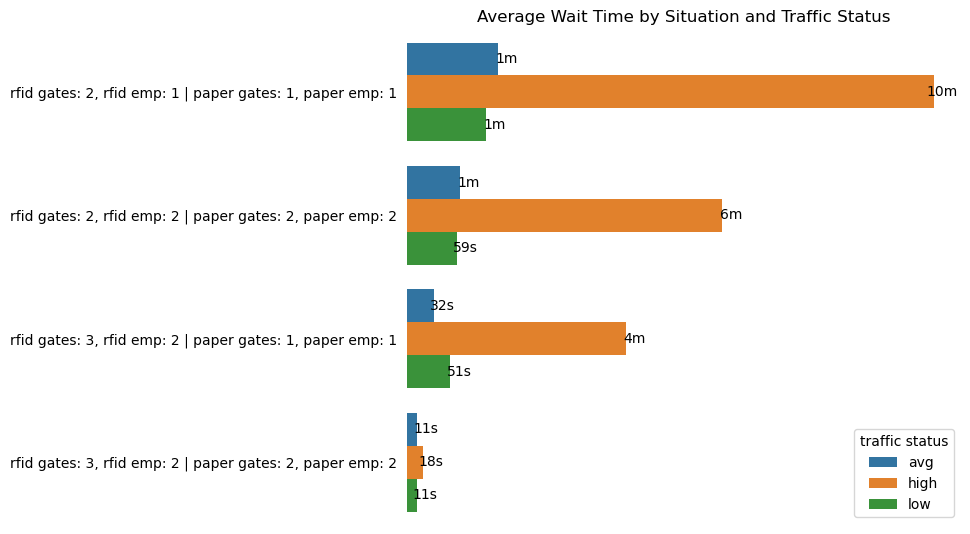

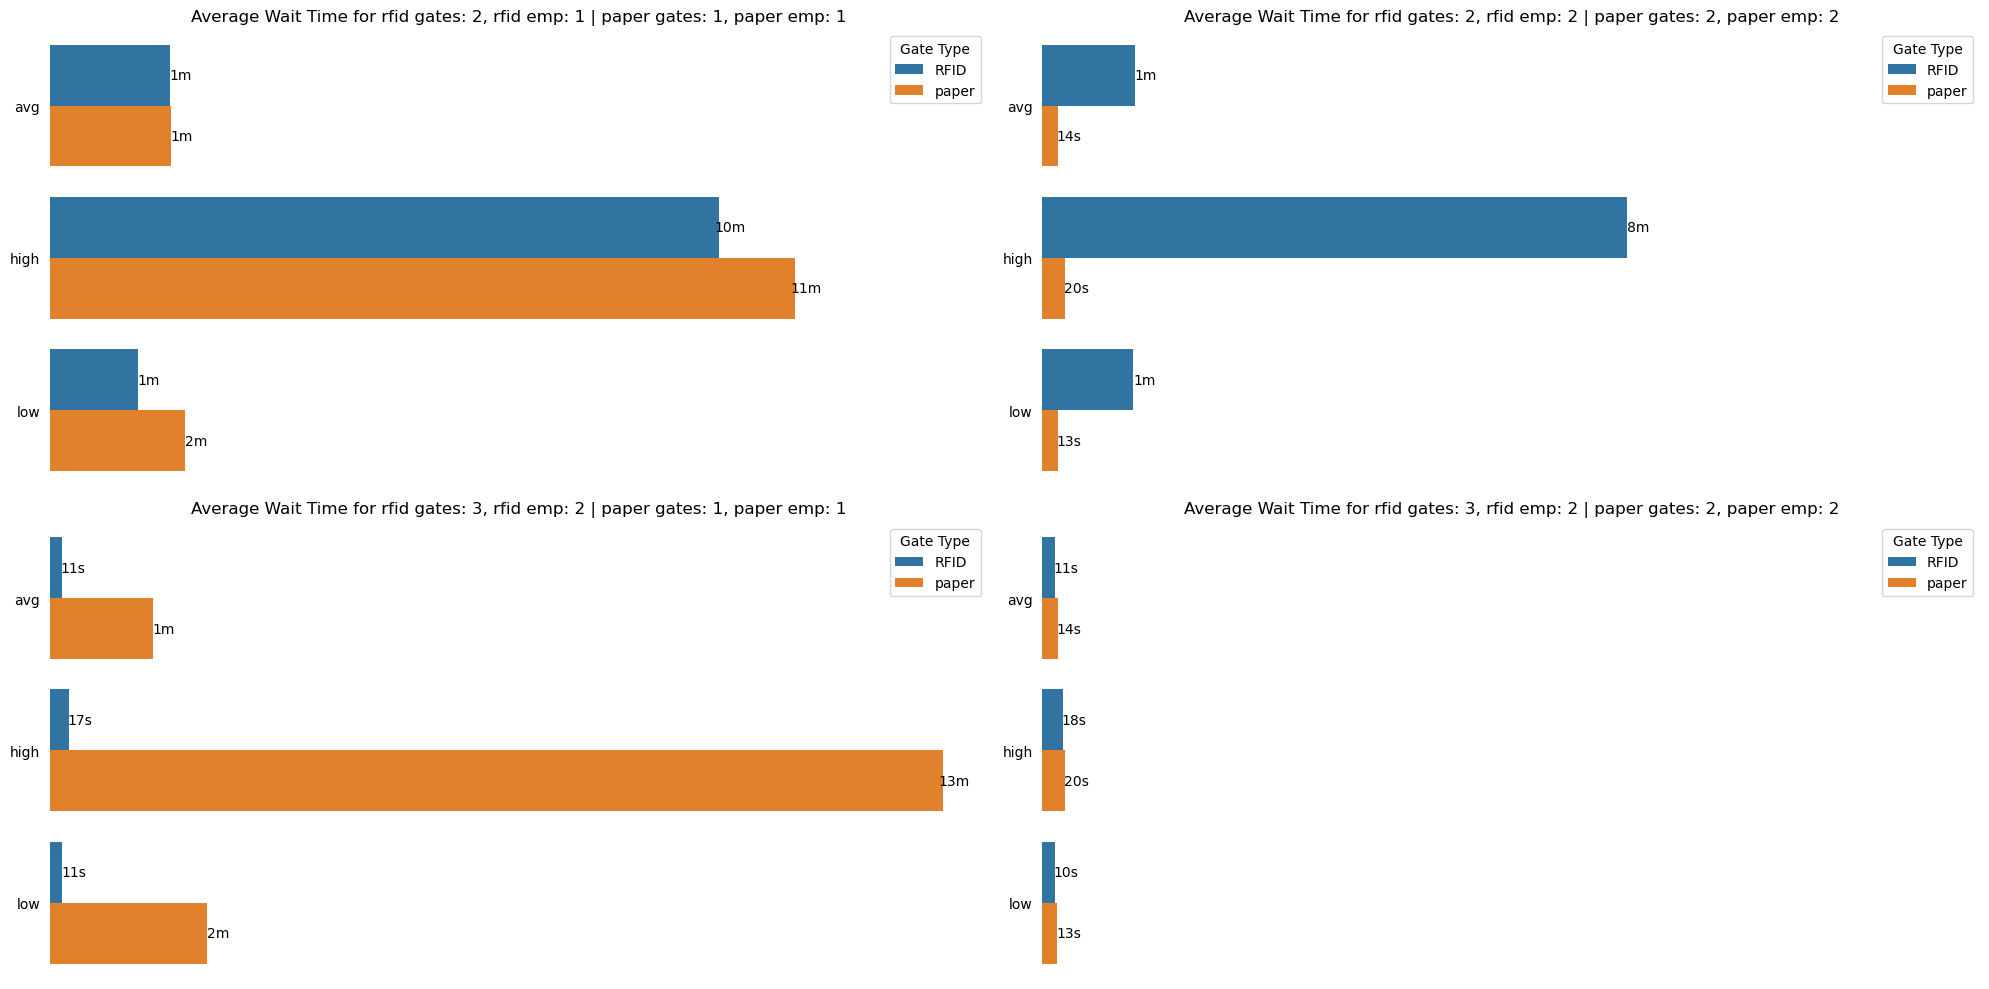

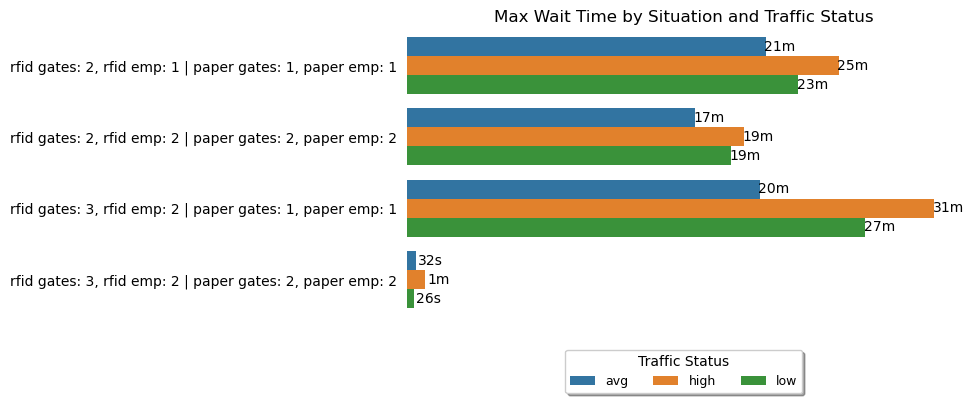

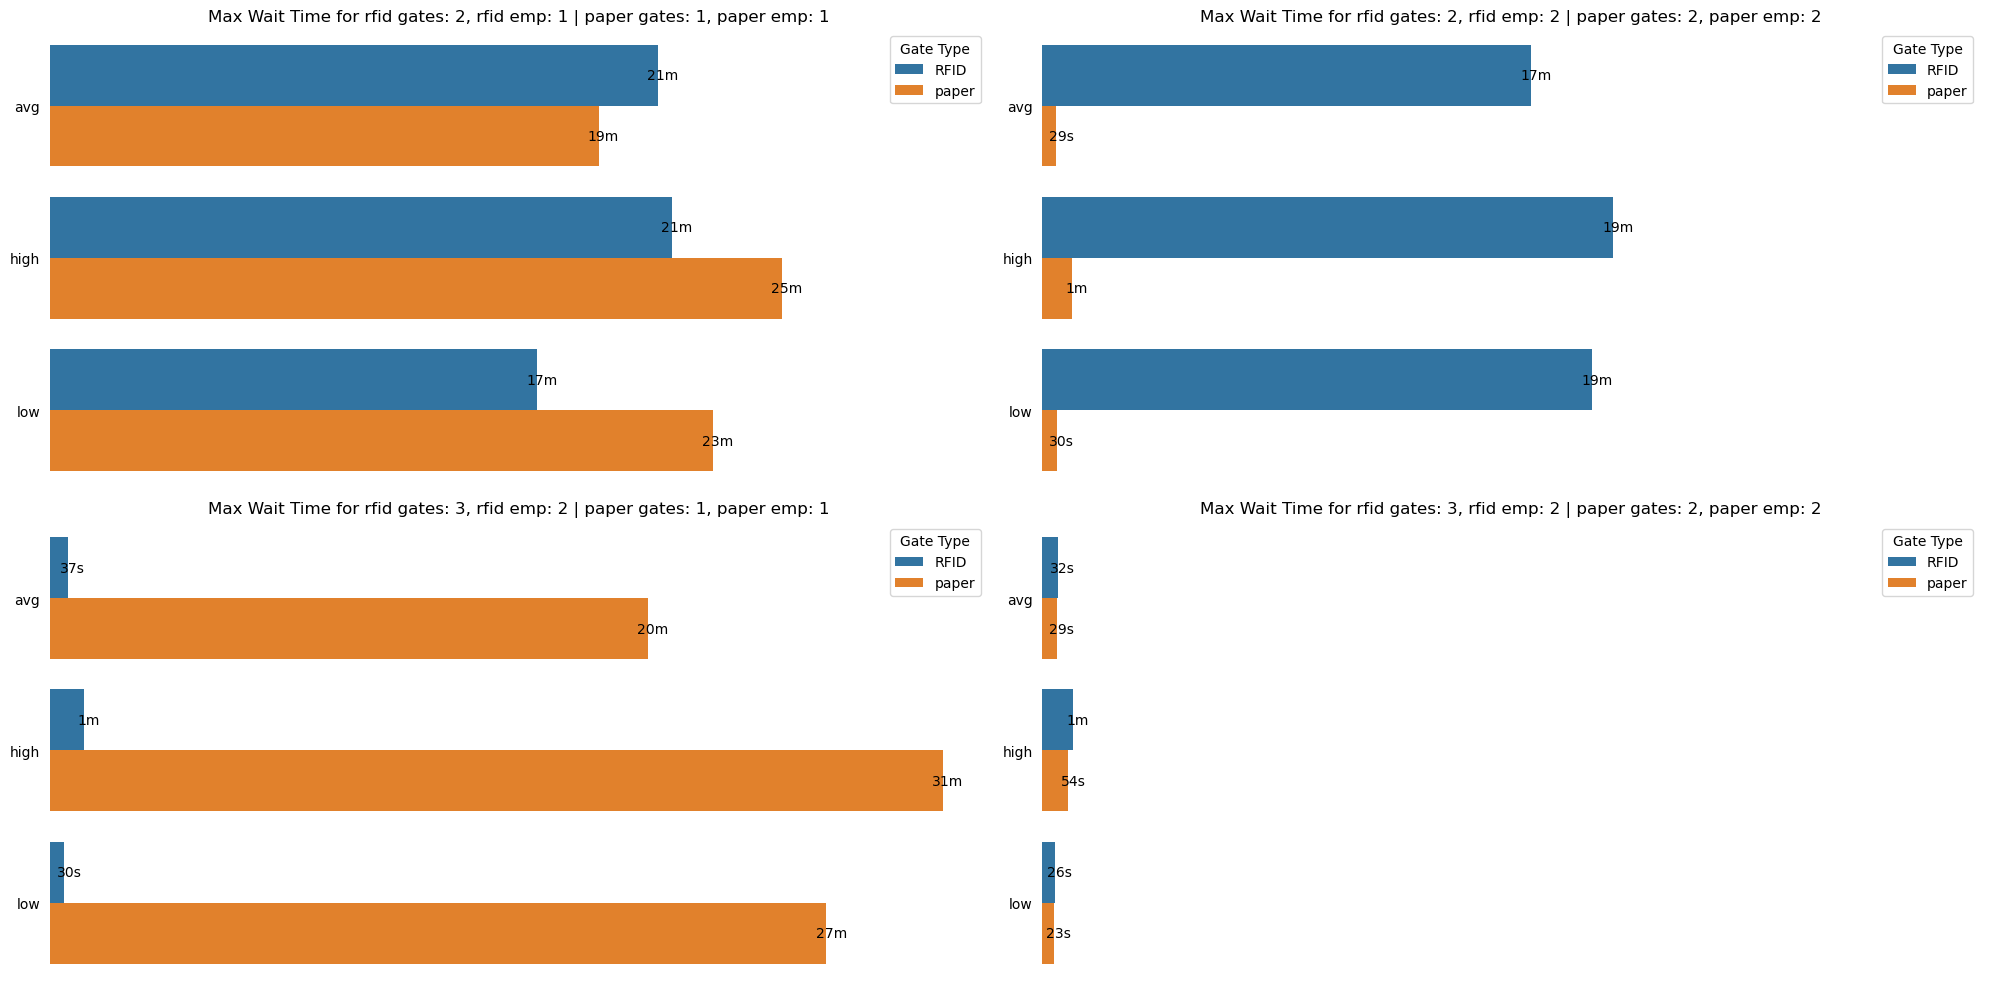

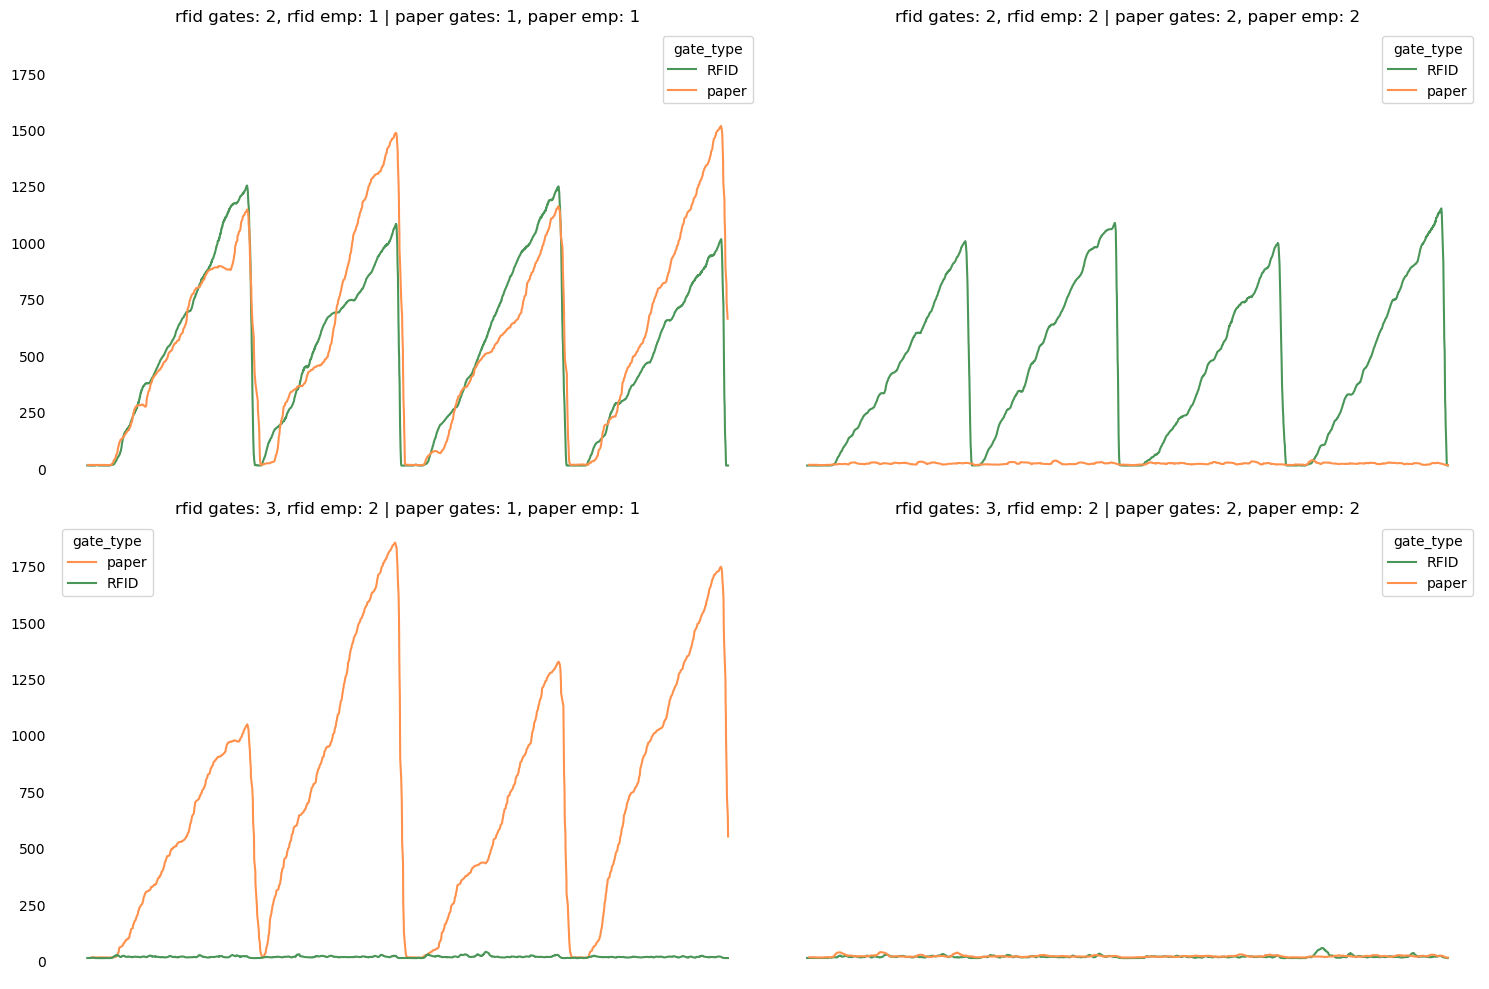

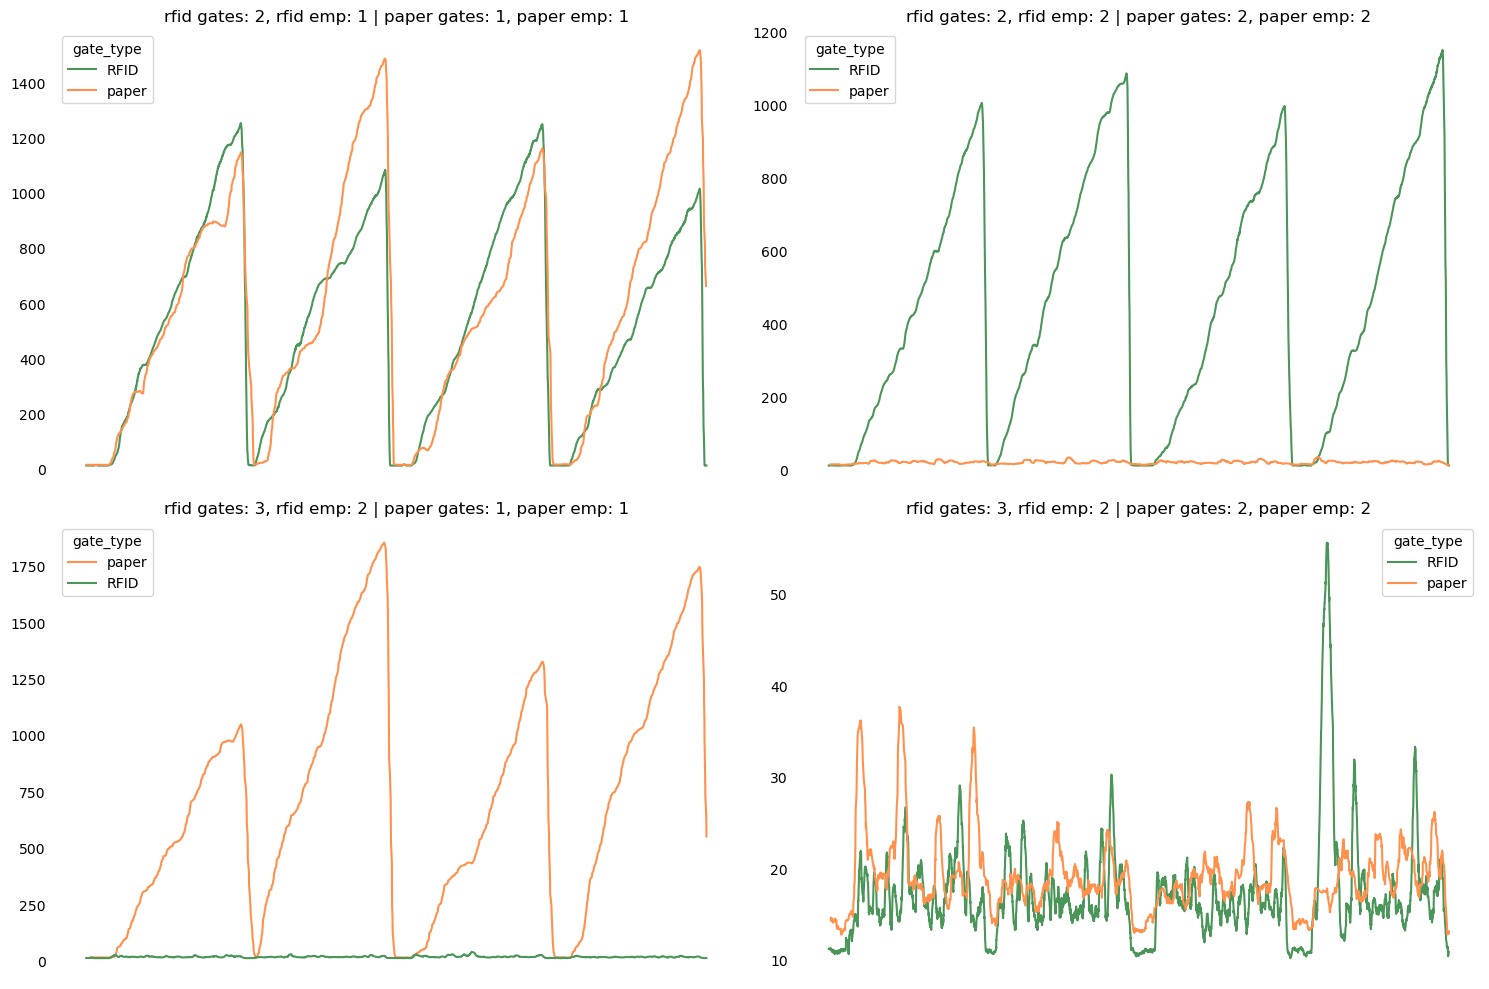

In [71]:
wait_time_df = read_in_data()
situations = wait_time_df['situation'].unique()
single_mean_wait()
situational_mean_wait(situations)
single_max_wait()
situational_max_wait(situations)
plot_moving_avg(situations,sharey=True)
plot_moving_avg(situations,sharey=False)